# (2025) Graded Exercise 1: Eye tracking

## Please write your name and student ID here: YOOJIN Kim (402772)

#### For submission, make sure to save your notebook with valid outputs for grading. Do not leave a lot of confusing debug output in your cells. 

**100 points** in total (+5 bonus).

The different parts of the exercise are designed to be independent. Since we attempt to use only the simple techniques seen in class for rather complex tasks, results may not always be perfect.

In [1]:
# Uncomment and run the code below in case you have library issues
# %pip install numpy==1.26.4
# %pip install matplotlib==3.9.2

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

# We provide a helper function to read sequences:
from load_sequence import load_sequence, visualize_sequence

## Part 1 - Data exploration

**Eye tracking** is an important task in computer vision. By analyzing eye movements, gaze direction, and blinks, we gain insights into user behavior and interaction patterns. This has wide-ranging applications, including:
* medical diagnostics, aiding in detecting neurological disorders such as autism or Parkinson’s disease;
* driver monitoring systems, improving safety by detecting drowsiness or distraction
* virtual and augmented reality (VR/AR), where it enhances immersion through gaze-based navigation and high-resolution rendering.

Below, we include a diagram of the eye. Most importantly, we will refer to the iris (the round, colorful part) and the sclera (the white part). *If the image does not display in your notebook, you can view it in the `data` folder.*

<div style="text-align: center;">
    <img src="data/scheme_eye.png" alt="Eye Scheme" width="50%"/>
</div>

In this exercise, we will provide as input some videos of eyes and our goal will be to localize the eye, identify blinking frames, and estimate gaze direction. First, let's have a look at the data.



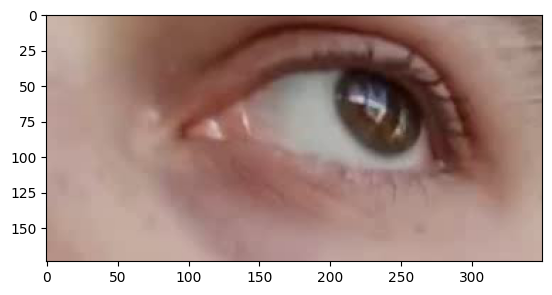

Image shape: (174, 350, 3)


In [3]:
imgs, seg_gts, blink_frames = load_sequence(os.path.join("data", "sequence1"))
plt.imshow(imgs[0])
plt.show()
print("Image shape:", imgs[0].shape)

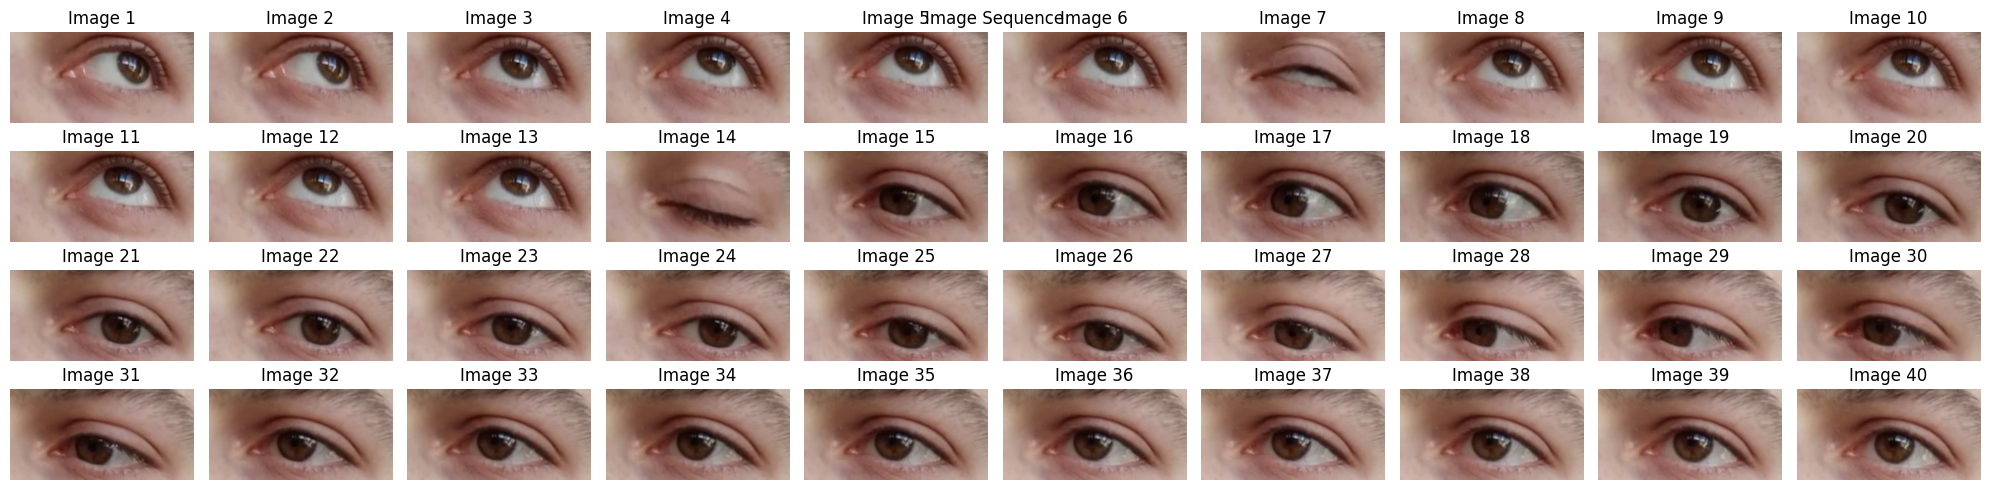

In [4]:
visualize_sequence(imgs)

For some frames, we provide ground-truth, for example iris segmentation. We will use this information for evaluation.

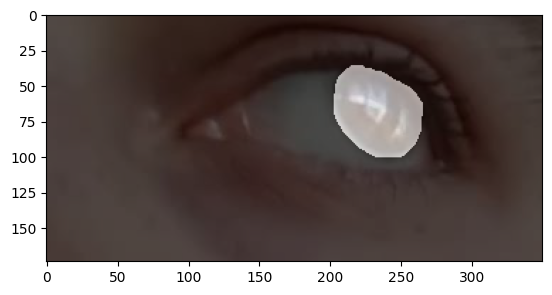

In [5]:
# Here we visualize the ground-truth overlaid on the image
plt.imshow(0.4 * imgs[0] + 0.6 * seg_gts[0][:,:,:3])
plt.show()

**QUESTION 1.1 (5 pts).** It would be nice to have an idea about the size of the data before we get started. Write a function that returns **the total number of pixels** in the complete sequence. You can assume that all images have the same shape. HINT: You will probably need to use `np.shape` or `np.size`.

In [6]:
def number_of_pixels(imgs):
    ### YOUR ANSWER HERE ###
    h, w, c = imgs[0].shape
    size = len(imgs) * h * w
    ### END OF YOUR ANSWER ###

    return size

number_of_pixels(imgs)

2618700

## Part 2 - Localizing the iris

The goal of this section is to at the very end display the video of the eye in which real-time the iris contour is identified and drawn.

In [7]:
# Let's first convert the images to greyscale
imgs_gray = [np.mean(img, axis=-1) for img in imgs] # Convert to grayscale
gray = imgs_gray[0]
print(f"Shape modified from {imgs[0].shape} to {imgs_gray[0].shape}")

Shape modified from (174, 350, 3) to (174, 350)


Identifying the iris in an image is tricky - different people have different eye colors, skin color, or eye shape. Even worse, the image could be captured from very different angles, making it hard to design a method that will work robustly on all sequences.

Let's first try something simple using the tools we have already seen in class: finding edges in the image and choosing the right edge to fit a circle or an ellipse to.

In [8]:
kernels = {
    "A" : (1/3) * np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]),

    "B": np.array([
        [ 0, -1,  0],
        [-1,  4, -1],
        [ 0, -1,  0]
    ]),
    
    "C" :np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]),

    "D": (1/8) * np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ]),

    "E": np.array([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]
    ]),
}

**QUESTION 2.1 (5 pts).** We have defined several kernels above. Which one(s) can be used as an edge detector? Explain why.

ANSWER:
* A: No. A is a diagonal average filter so it will smooth along the diagonal.
* B: Yes. B is a Laplacian kernel with 4 neighbors. If the value of a pixel is different from its neighbors, it will lead to high values. It works by subtracting the surrounding pixel values from the center, which enhances the edges. 
* C: No. C is an identity kernel, which just returns the original pixel value.
* D: No. D is a mean filter (blur), which smooths the image and actually removes edges.
* E: Yes. E is a Laplacian kernel with 8 neighbors, which makes it more sensitive to edges in all directions.

**QUESTION 2.2 (5 pts).** Let's now implement the `apply_kernel` function, which manually performs convolution between the filter and the image:

In [9]:
def apply_kernel(image, kernel):
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2  # padding size
    padded_image = np.pad(image, pad, mode='edge')  
    filtered_image = np.zeros_like(image, dtype=np.float32)

    ### YOUR ANSWER HERE ###
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            filtered_image[i, j] = np.sum(region * kernel)
    ### END OF YOUR ANSWER ###

    
    return filtered_image

Now let's visualize the effects of the proposed filters:

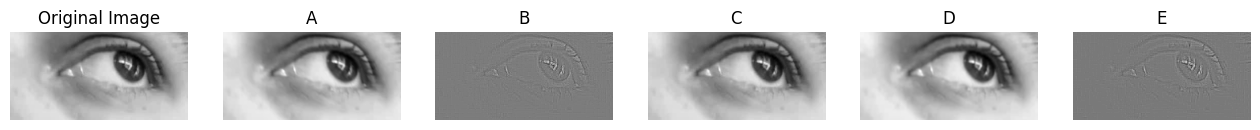

In [10]:
# Apply all filters and display
filtered_images = {name: apply_kernel(gray, kernel) for name, kernel in kernels.items()}
n = len(filtered_images) + 1
fig, axes = plt.subplots(1, n, figsize=(16, 6))

axes[0].set_title("Original Image")
axes[0].imshow(gray, cmap='gray')
axes[0].axis("off")

for idx, (name, img) in enumerate(filtered_images.items()): 
    axes[idx + 1].set_title(name)
    axes[idx + 1].imshow(img, cmap='gray')
    axes[idx + 1].axis("off")

plt.show()

**Sobel Filter**

The **Sobel filter** is a widely used edge detection operator that computes the gradient of an image in the **x** and **y** directions. It helps identify regions of rapid intensity change, which typically correspond to edges in an image. The Sobel operator applies **two 3×3 convolution kernels**, one for detecting horizontal edges (**Gx**) and one for detecting vertical edges (**Gy**):

$$
G_x =
\begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix}
$$

$$
G_y =
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
+1 & +2 & +1
\end{bmatrix}
$$

Given an input image \( I \), the filtered images are computed as:
$$
S_x = I * G_x, \quad S_y = I * G_y
$$
where \( * \) denotes convolution. The overall gradient magnitude at each pixel is then computed as:
$$
S = \sqrt{S_x^2 + S_y^2}
$$
This combines both directional gradients into a single *edge strength* representation.

**QUESTION 2.3 (10 pts).** Implement the **Sobel filter**, as explained above.

In [11]:
def sobel_filter(img):
    """
    Applies the Sobel filter to an input grayscale image.
    
    Args:
        img (numpy.ndarray): Grayscale image of shape (H, W)
    
    Returns:
        sobel_x (numpy.ndarray): Gradient in the x-direction
        sobel_y (numpy.ndarray): Gradient in the y-direction
        sobel (numpy.ndarray): Gradient magnitude
    """
    
    ### YOUR ANSWER HERE ###
    Gx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]])
    Gy = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]]) 

    sobel_x = apply_kernel(img, Gx).astype(np.float32)
    sobel_y = apply_kernel(img, Gy).astype(np.float32)
    # HINT: If you attempt to square an array of 8-bit integers, it can overflow.
    # You can convert it to float with array.astype(np.float32)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    ### END OF YOUR ANSWER ###


    return sobel_x, sobel_y, sobel

sobel_x, sobel_y, sobel = sobel_filter(gray)

Let's visualize the different outputs:

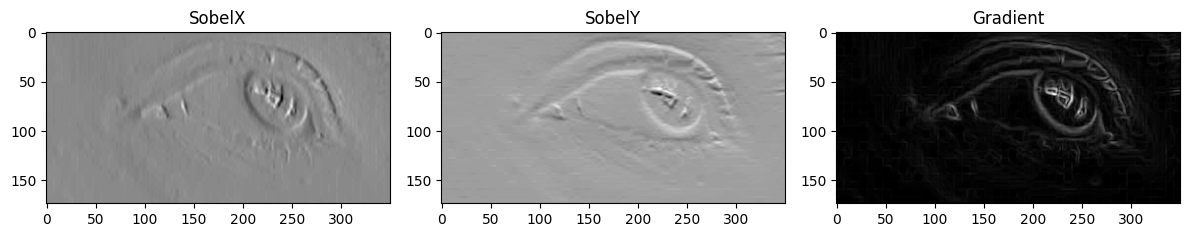

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

ax3 = plt.subplot(1,3,1)  
ax3.set_title('SobelX')
ax3.imshow(sobel_x, cmap='gray')

ax4 = plt.subplot(1,3,2)
ax4.set_title('SobelY')
ax4.imshow(sobel_y,cmap='gray' )

ax5 = plt.subplot(1,3,3)
ax5.set_title('Gradient')
ax5.imshow(sobel, cmap='gray')

plt.tight_layout()
plt.show()


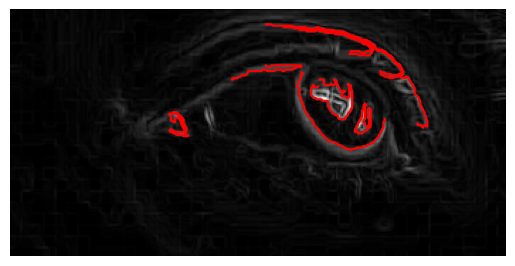

In [13]:
from find_contours import find_contours
sobel_x, sobel_y, sobel_image = sobel_filter(imgs_gray[0])

# Normalize and convert Sobel image to binary
sobel_image = (sobel_image - sobel_image.min()) / (sobel_image.max() - sobel_image.min()) 
threshold_value = 0.2
binary_sobel = (sobel_image > threshold_value) * 255
binary_sobel = binary_sobel.astype(np.uint8) 

sobel_contours = find_contours(binary_sobel)

# Discard tiny components
filtered_sobel_contours = []
for i in range(len(sobel_contours)):
    if sobel_contours[i].shape[0] >= 70:
        filtered_sobel_contours.append(sobel_contours[i])

plt.imshow(sobel_image, cmap='gray')
for contour in filtered_sobel_contours:
    contour = np.array(contour)
    plt.plot(contour[:, 0], contour[:, 1], 'r', linewidth=1.5)  # Draw contours
plt.axis("off")
plt.show()

sobel_contours = filtered_sobel_contours


To fit an ellipse to a given set of contour points $(x_i, y_i)$, we assume a general quadratic equation:

$$
A x^2 + B x y + C y^2 + D x + E y + F = 0
$$

We construct a **design matrix** $D$ where each row corresponds to a data point:

$$
D =
\begin{bmatrix}
x_1^2 & x_1 y_1 & y_1^2 & x_1 & y_1 & 1 \\
x_2^2 & x_2 y_2 & y_2^2 & x_2 & y_2 & 1 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_N^2 & x_N y_N & y_N^2 & x_N & y_N & 1
\end{bmatrix}
$$

Since we want to find the vector $p = (A, B, C, D, E, F)^T$ that satisfies $Dp = 0$, we solve for $p$ using **Singular Value Decomposition (SVD)**. SVD decomposes \(D\) into:

$$
D = U S V^T
$$

where $U$ and $V$ are orthogonal matrices and $S$ is a diagonal matrix of singular values. The solution to $Dp = 0$ is then given by the **right singular vector** of $D$ corresponding to the smallest singular value, which is the last row of $V^T$.

**QUESTION 2.4 (5 pts).** Implement the `fit_ellipse` function, as explained above.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from ellipse_utils import recover_ellipse_parameters, plot_ellipse

def fit_ellipse(x, y):
    """Fit an ellipse to given points using least squares."""
    ### YOUR ANSWER HERE ###
    D = np.column_stack([x**2, x*y, y**2, x, y, np.ones_like(x)])
    U, S, VT = np.linalg.svd(D)
    ellipse_params = VT[-1, :]
    ### END OF YOUR ANSWER ###


    return ellipse_params

example_countour = sobel_contours[0]
ellipse_params = fit_ellipse(x=example_countour[:,0], y=example_countour[:,1])

Of course, the `fit_ellipse` function will fit an ellipse to any contour - it remains to find which one is most likely to be the iris. To this end, we will now assign a score to each contour, and keep only the one with the highest score.

An ellipse can be characterized by an origin 2D point $(x_0, y_0)$, the half-length of its long axis $a$ and short axis $b$, and a rotation angle $\theta$. 

<div style="text-align: center;">
    <img src="data/diagram_ellipse.png" alt="Ellipse diagram" width="25%"/>
</div>

- First, we would like to measure **how well the fitted ellipse matches the given data**. A natural way to evaluate this is by computing the **residual error** of each point in the previous equation:

$$
\text{Residual} = \frac{1}{N} \sum_{i=1}^{N} \left| A x_i^2 + B x_i y_i + C y_i^2 + D x_i + E y_i + F \right|
$$

This residual represents how far each data point is from satisfying the implicit conic equation. Since we want a **higher score for better fits**, we take the **inverse** of the error and scale it by $a \times b$ to favor larger ellipses:

$$
\text{Fit Quality} = \frac{a \times b}{\text{Residual} + \epsilon}
$$

where $\epsilon$ is a small value to avoid division by zero.

- Second, we will **favor round ellipses** to exclude contours from the eyelashes. We thus define a **circularity score** based on $a$ and $b$:

$$
\text{Circularity} = \exp\left(- \left| \frac{a}{b} - 1 \right| \right)
$$

If $a \approx b$, the circularity score is **close to 1** (ideal circle), but if $a \gg b$ or $b \gg a$, the circularity score **decreases exponentially**.

Given a parameter $\alpha = 0.001$, we combine **fit quality** and **circularity** into an overall **score**:

$$
\text{Score} = \text{Fit Quality} + \alpha \times \text{Circularity}
$$

**QUESTION 2.5 (10 pts).** Compute the ellipse score.

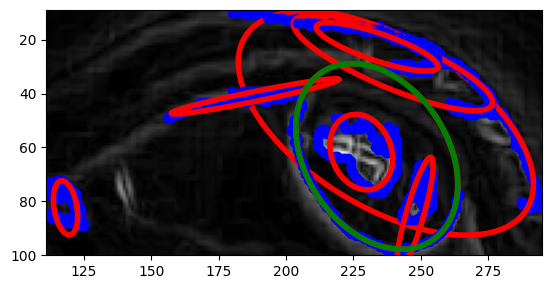

In [15]:
fig, ax = plt.subplots()
plt.imshow(sobel_image, cmap='gray')

best_score = - np.inf
best = -1
best_ellipse = None
for i, contour in enumerate(sobel_contours):
    x, y = contour[:,0], contour[:,1]

    A, B, C, D, E, F = fit_ellipse(x, y)
    orig, axes, theta = recover_ellipse_parameters(A, B, C, D, E, F) # This is not straightforward, it is provided
    
    if orig is None: # Exclude degenerate ellipses
        continue
    a, b = axes
    x0, y0 = orig

    ### YOUR ANSWER HERE ###
    residuals = A*x**2 + B*x*y + C*y**2 + D*x + E*y + F
    residual = np.mean(np.abs(residuals))
    fit_quality =  (a * b) / (residual + 1e-8)
    circularity = np.exp(-np.abs(a/b - 1))
    score = fit_quality + 0.001 * circularity

    ### END OF YOUR ANSWER ###


    if score > best_score:
        best_score = score
        best = i
        best_ellipse = (A, B, C, D, E, F)

    ax.plot(x, y, 'bo', markersize=6)
    plot_ellipse(A, B, C, D, E, F, ax, color='r', linestyle='-')

if best_ellipse:
    plot_ellipse(*best_ellipse, ax, color='g', linestyle='-')

all_points = np.vstack(sobel_contours)
xmin, ymin = all_points.min(axis=0)
xmax, ymax = all_points.max(axis=0)
ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

ax.invert_yaxis()
ax.set_aspect('equal')
plt.show()

Now let's visualize the identified region along with the GT.

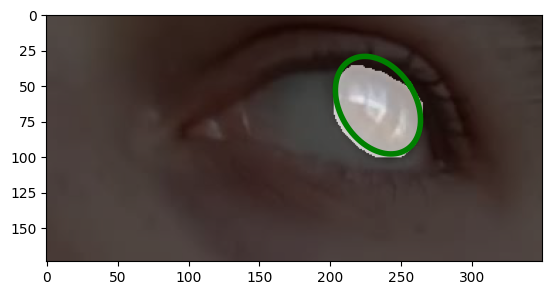

In [16]:
fig, ax = plt.subplots()
ax.imshow(0.4 * imgs[0] + 0.6 * seg_gts[0][:, :, :3])  # Overlay GT segmentation on the image

# Plot the best ellipse on top of the GT
if best_ellipse:
    plot_ellipse(*best_ellipse, ax, color='g', linestyle='-')

ax.set_aspect('equal')
plt.show()

**QUESTION 2.6 (5 pts).** What are the limitations of this method? How would you improve it? In particular, what method seen in class *recently* could be applied here?

ANSWER: One limitation of the current method is its reliance on noisy contour detection and the assumption that contours follow an elliptical shape. It also does not account for high-levle shape consistency or robustness to partial occlusion. A possible improvement would be to use the Generalized Hough Transfrom, which uses an R-table to detect shapes based on edge orientation and relative position. This approach uses gradient directions and a model-based voting mechanism to robustly detect object shape like ellipses, even in cluttered or partially visible regions.

## Part 3 - Blink Detection
In this part of the lab, we will focus on detecting frames in which the person is blinking by analyzing changes in the visual features of the eye. A blink is characterized by the closing of the eyelid, which typically results in a decrease in the visible area of the sclera. 

Quite simply, we will attempt to segment the sclera, and then calculate its area. A significant reduction in this area compared to other frames could indicate a blink.

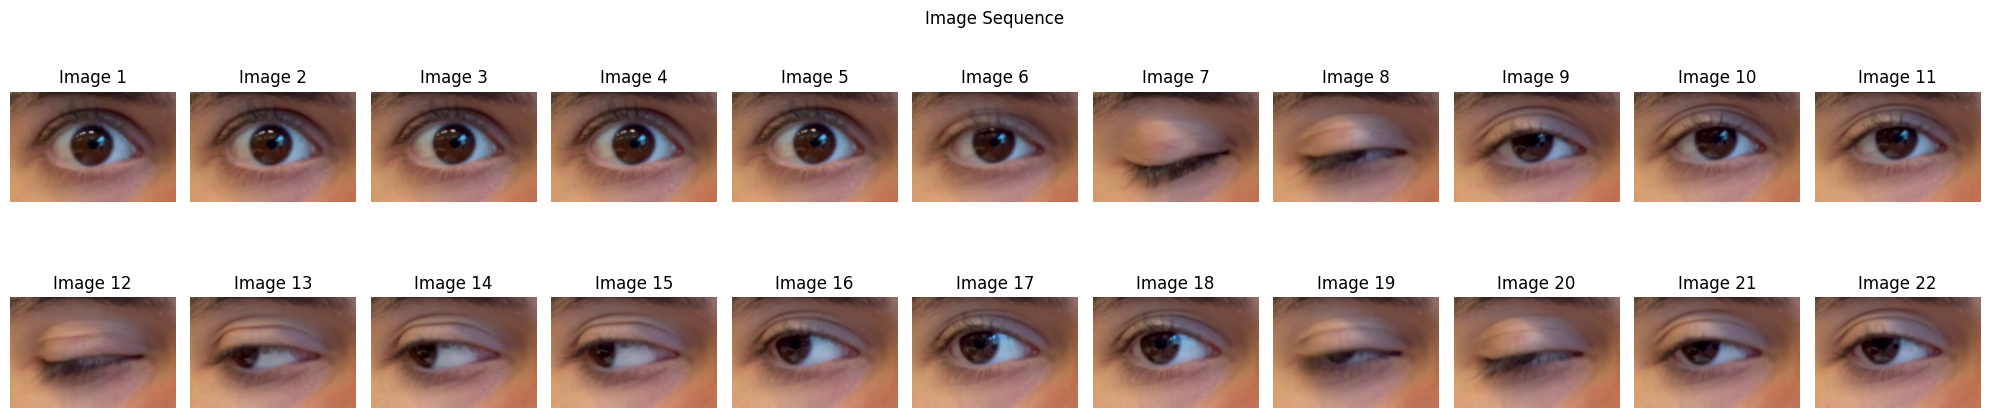

In [17]:
imgs, seg_gts, blink_frames = load_sequence(os.path.join("data", "sequence3"))
visualize_sequence(imgs, rows=2)

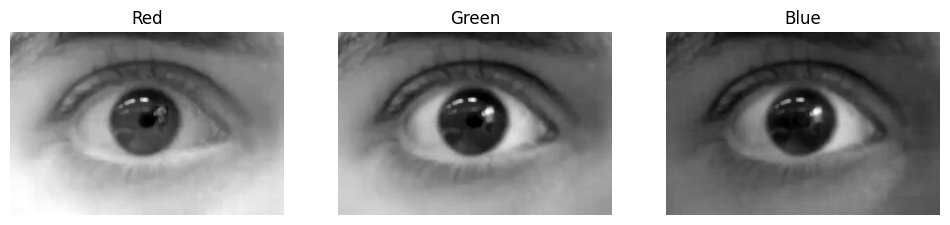

In [18]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(imgs[0][:,:,0], cmap='gray')
plt.title("Red")
plt.axis('off')

plt.subplot(132)
plt.imshow(imgs[0][:,:,1], cmap='gray')
plt.title("Green")
plt.axis('off')

plt.subplot(133)
plt.imshow(imgs[0][:,:,2], cmap='gray')
plt.title("Blue")
plt.axis('off')
plt.show()

**QUESTION 3.1 (5 pts).** Which channel seems to be the most appropriate for segmenting the sclera, and why? *(assuming you use a single one)*

ANSWER: **Blue**, because it provides the highest contrast between the sclera (the white part of the eye) and surrounding regions like the iris, eyelid, and skin. In the red channel, the skin and sclera have similar intensities, making segmentation harder. The green channel is better than red, but the blue channel shows the sclera as much brighter compared to its surroundings, making thresholding or segmentation more effective.

Let's now use this channel with an appropriate threshold to segment the white part of the eye.

**QUESTION 3.2 (5 pts).** Set the appropriate threshold and channel, and segment the image. Set the segmented pixels to 255, and all others to 0. You may use `np.where`.

In [19]:
def threshold_sclera_with_rgb(img):
    """
    Applies a thresholding operation to extract the sclera from an RGB image.
    
    Args:
        img (numpy.ndarray): Input RGB image of shape (H, W, 3), where H is height, W is width.

    Returns:
        numpy.ndarray: A binary thresholded image of shape (H, W), where:
            - White (255) represents detected sclera regions.
            - Black (0) represents non-sclera regions.
    """
    
    ### YOUR ANSWER HERE ###
    blue = img[:, :, 2]
    #print(blue)
    img_tmp = np.where(blue > 0.6, 255, 0)
    ### END OF YOUR ANSWER ###

    
    return img_tmp.astype(np.uint8)

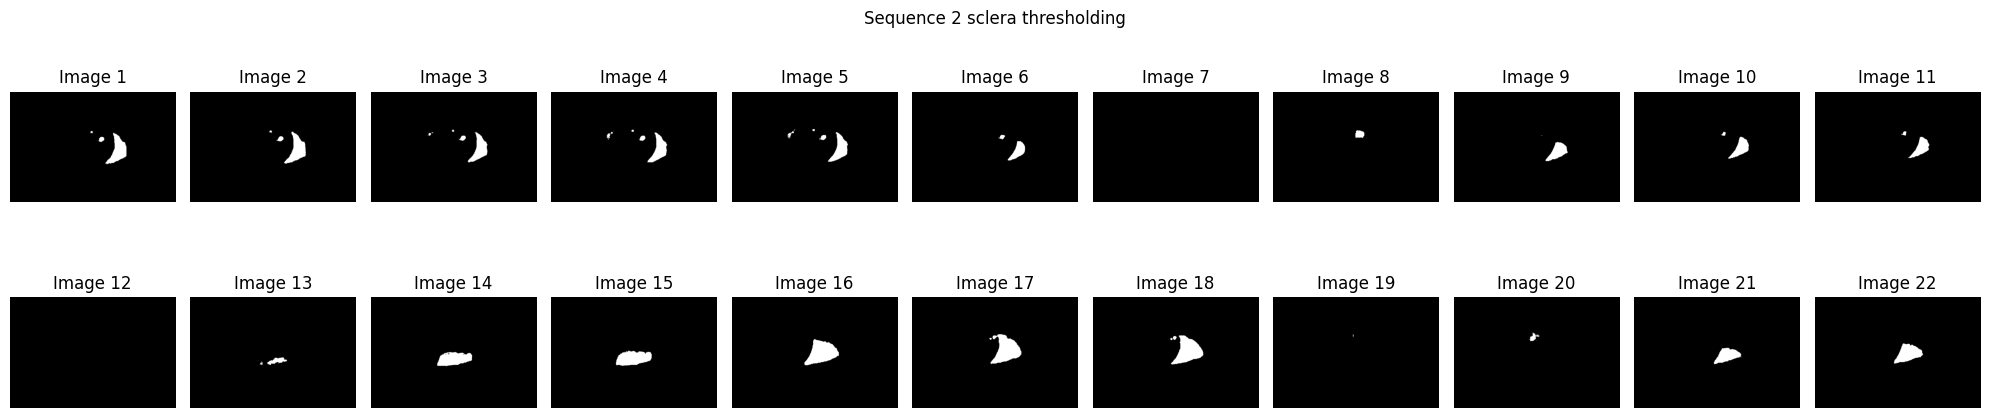

In [20]:
nb_img_per_row = len(imgs) // 2
fig, axs = plt.subplots(2, nb_img_per_row, figsize=(20, 5))
for i in range(2 * nb_img_per_row):
    axs[i // nb_img_per_row, i % nb_img_per_row].imshow(threshold_sclera_with_rgb(imgs[i]), cmap='gray')
    axs[i // nb_img_per_row, i % nb_img_per_row].axis('off')
    axs[i // nb_img_per_row, i % nb_img_per_row].set_title(f"Image {i+1}")
plt.tight_layout()
plt.suptitle("Sequence 2 sclera thresholding")
plt.show()

**QUESTION 3.3 (10 pts).** Implement the `is_blink` function. You can use `np.sum` to sum all values in an array.

In [21]:
def is_blink(img_th):
    ### YOUR ANSWER HERE ###
    ratio_min = 0.01
    sclera_pixels = np.sum([img_th == 255])
    total_pixels = img_th.size
    ratio = sclera_pixels / total_pixels
    return ratio_min > ratio
    ### END OF YOUR ANSWER ###



To evaluate the performance of your blink detection algorithm, we will use some metrics such as precision, recall, and F1-score. These metrics will help us understand how well our algorithm is performing in terms of detecting blinks.

Formulas : 

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

$$ \text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$

**True Positives** (TP) are the frames where a blink is correctly detected, **False Positives** (FP) are the frames where a blink is incorrectly detected, and **False Negatives** (FN) are the frames where a blink is missed.

Hint : you can use [`np.logical_and`](https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html) and [`np.logical_not`](https://numpy.org/doc/2.2/reference/generated/numpy.logical_not.html) to compare two arrays of the same shape.

**QUESTION 3.4 (10 pts).** Implement the following functions.

In [22]:
gt_blink = blink_frames

def recall(predicted, ground_truth):
    ### YOUR ANSWER HERE ###
    TP = np.logical_and(predicted, ground_truth).sum()
    FN = np.logical_and(np.logical_not(predicted), ground_truth).sum()
    return TP / (TP + FN) if (TP + FN) != 0 else 0.0
    ### END OF YOUR ANSWER ###


def precision(predicted, ground_truth):
    ### YOUR ANSWER HERE ###
    TP = np.logical_and(predicted, ground_truth).sum()
    FP = np.logical_and(predicted, np.logical_not(ground_truth)).sum()
    return TP / (TP + FP) if (TP + FP) != 0 else 0.0 
    ### END OF YOUR ANSWER ###


def f1_score(predicted, ground_truth):
    ### YOUR ANSWER HERE ###
    precision_value = precision(predicted, ground_truth)
    recall_value = recall(predicted, ground_truth)
    return 2 * precision_value * recall_value / (precision_value + recall_value) if (precision_value + recall_value) != 0 else 0.0
    ### END OF YOUR ANSWER ###



In [23]:
# Don't worry if your score is not perfect
pred = np.array([], dtype=int)
for i in range(len(imgs)):
    img_th = threshold_sclera_with_rgb(imgs[i])
    if is_blink(img_th):
        pred = np.append(pred, 1)
    else:
        pred = np.append(pred, 0)

print("Prediction:", pred)
print("Recall:", recall(pred, gt_blink))
print("Precision:", precision(pred, gt_blink))
print("F1 score:", f1_score(pred, gt_blink))

Prediction: [0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0]
Recall: 1.0
Precision: 0.7142857142857143
F1 score: 0.8333333333333333


**QUESTION 3.5 (5 pts).** What are the limitations of this method? How would you improve it?

ANSWER: The current method relies on fixed thresholding of the blue channel, making it sensitive to lighting and skin tone. It doesn't localize the eye region, leading to possible false detections. Also, small eye movements can be mistaken for blinks. To improve it, we could use a more robust color space like HSV or LAB. Adaptive thresholding could also increase accuracy. Moreover, using the Generalized Hough Transform would enable more reliable detection of eye shape and movement, leading to more accurate blink detection.

## Part 4 - Gaze Estimation

Gaze estimation is used to enable devices to interpret where a person is looking and respond intelligently. In this question, you will explore gaze estimation using some of the techniques seen in class.

### 4.1 Gaze Classification

Let's start with a simple task. Given an image of an eye, your goal is to classify whether it is looking to the left or right. You can assume that the images are unambiguous and can be reliably classified.

You are provided with four key points, corresponding to the vertices and co-vertices of an ellipse fitted to the sclera. These ellipses could have been obtained through similar methods as the ones described in the previous section, but for the sake of making the parts fully independent, we will load them from a file here.

**QUESTION 4.1.1 (5 pts).** Use the provided points to crop the image using the min/max of points on each axis.

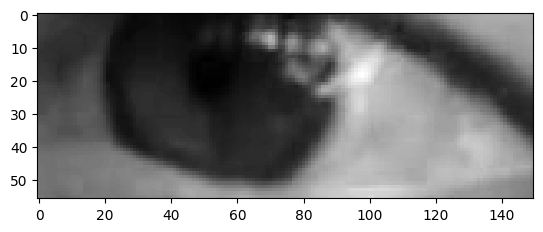

In [24]:
imgs, _, _ = load_sequence(os.path.join("data", "sequence1"))
image = imgs[15] # We'll work on this image in this section
image = 255 * image.mean(axis=-1) # Greyscale
vertices = np.load('data/vertices.npy', allow_pickle=True)


def crop_image(image, vertices):
    ### YOUR ANSWER HERE ###
    rows = vertices[:, 1]
    cols = vertices[:, 0]
    cropped_image = image[min(rows):max(rows)+1, min(cols):max(cols)+1]
    ### END OF YOUR ANSWER ###


    return cropped_image

image_eye = crop_image(image, vertices)
plt.imshow(image_eye, cmap='gray')
plt.show()

**QUESTION 4.1.2 (5 pts).** Now threshold the image, setting appropriate value(s). You may use `np.where`.

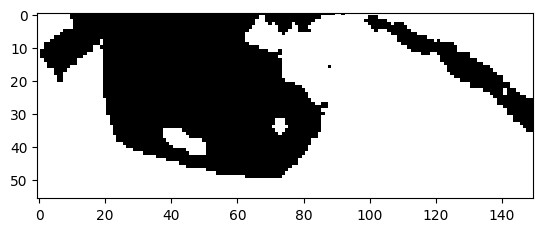

In [25]:
def threshold(img):
    ### YOUR ANSWER HERE ###
    th_img = np.where(img < 40, 0, 255).astype(np.uint8)
    ### END OF YOUR ANSWER ###

    return th_img

mask_eye = threshold(image_eye)
plt.imshow(mask_eye, cmap='gray')
plt.show()

In [26]:
h, w = mask_eye.shape
left_half = mask_eye[:, :w//2]
right_half = mask_eye[:, w//2+1:]

dark_left_half = np.sum(left_half == 0)
dark_right_half = np.sum(right_half == 0)
print(f'The number of dark pixels on the left is: {dark_left_half}')
print(f'The number of dark pixels on the right is: {dark_right_half}')
left_or_right = dark_left_half > dark_right_half
if left_or_right:
    print('The gaze is on the left')
else:
    print('The gaze is on the right')

The number of dark pixels on the left is: 2539
The number of dark pixels on the right is: 577
The gaze is on the left


## 4.2 Gaze Direction

In this task, our focus is on determining the direction of gaze rather than classifying it. You may use the `vertices` as described in Section 4.1. Additionally, the center of the iris is provided in `data/iris_center.pkl`.

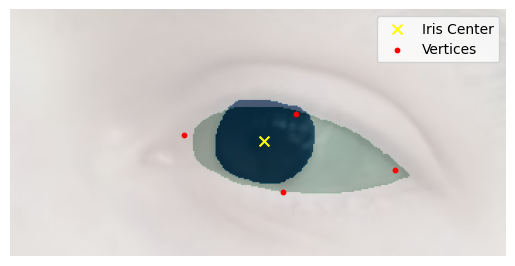

In [27]:
iris_center = np.load('data/iris_center.npy', allow_pickle=True)
frame = 'frame_0075'
image = plt.imread(f"data/sequence1/{frame}.png")
image_gray = image.mean(axis=-1)
mask_eye = plt.imread(f"data/sequence1_gt_eye/{frame}.png")
mask_iris = plt.imread(f"data/sequence1_gt/{frame}.png")

plt.imshow(image, alpha=1.0)
plt.imshow(mask_eye, cmap='Greens', alpha=0.5)
plt.imshow(mask_iris, cmap='Blues', alpha=0.5)
plt.scatter([iris_center[0]], [iris_center[1]], c='yellow', marker='x', s=50, label="Iris Center")
plt.scatter(vertices[:, 0], vertices[:, 1], c='red', marker='o', s=10, label="Vertices")

plt.axis("off")
plt.legend()
plt.show()


**QUESTION 4.2.1 (10 pts).** From the vertices and iris center, try to estimate the normalized gaze direction. You may need to use `np.sqrt` or `np.linalg.norm`.

In [28]:
def get_gaze_direction(vertices, iris_center):
    ### YOUR ANSWER HERE ###
    eye_center = np.mean(vertices, axis=0)
    vector = iris_center - eye_center
    print(vector)
    norm = np.linalg.norm(vector)
    print(norm)
    if norm == 0:
        direction = np.array([0.0, 0.0])
    else:
        direction = vector / norm
    ### END OF YOUR ANSWER ###

    
    return direction # Should be a unit vector

[-17.5  -8.5]
19.45507645834372


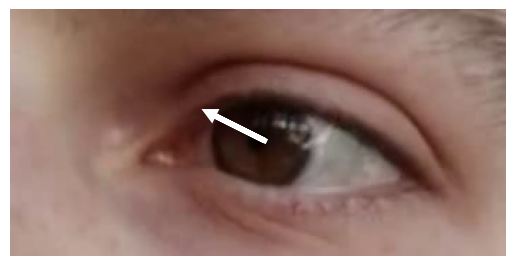

In [29]:
gaze_direction = get_gaze_direction(vertices, iris_center)

scale = 40
x_start, y_start = iris_center
x_end, y_end = (int(iris_center[0] + gaze_direction[0] * scale),
             int(iris_center[1] + gaze_direction[1] * scale))

plt.imshow(image, cmap='gray')
plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start, 
          head_width=5, head_length=5, fc='white', ec='white', linewidth=4)
plt.axis("off")
plt.show()

**QUESTION 4.2.2 (5 pts).** What are the limitations of this method? How can it be improved?

ANSWER: The method estimates gaze direction by calculating a vector from the average of eye contour vertices (eye center) to the iris center and normalizing it. While this approach is simple, but it has some limitations. Since it works in 2D image space, it doesn't account for the 3D shape of the eye or head movements, which can lead to inaccurate results. It also depends heavily on how accurately the iris center and eye contour are detected, so if there's noise or occlusion in the image, the estimated direction can be wrong. To improve this method, we could use 3D model to identify gaze direction, apply smoothing to reduce noise, or use a machine learning model trained on gaze data for reliable predictions.